# TME 10 : Compression d'images avec le codage de Huffman
> Consignes: le fichier **TME10_Sujet.ipynb** est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2018/course/view.php?id=4650. Si vous êtes en binôme, renommez-le en **TME10_nom1_nom2.ipynb**.

N'oubliez pas de sauvegarder fréquemment votre notebook !! ...

Pour chaque questions, écrivez des commentaires brefs et concis lorsque demandé dans les cases **Réponse**.

In [58]:
# Chargement des modules et fonctions utiles.
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from math import log


def affichage_14(affichages,titres=None, axis=True):
    # effectue entre 1 et 4 affichages avec leurs titres, pour des images ou courbes
    
    # paramètres :
    #  - liste des affichages (entre 1 et 4)
    #  - liste des titres (entre 1 et 4, autant que de affichages) Optionnelle
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('affichage_14 nécéssite 1 à 4 entrées en paramètre')        
        
    if nb_affichages != len(titres):
        raise ValueError('affichage_14 nécéssite autant de titres que d\'affichages')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True
        # ne pas afficher les axes si demandé
        if not axis:
            plt.axis('off')

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def litbit(s,b):
    """ bytearray*int->str
        lit la valeur du bit b dans la table d'octets s
        et retourne '1' ou '0'
    """
    byte , bit = b//8 , 7-b%8
    if s[byte] & (1<<bit):
        return '1'
    else:
        return '0'

def ecritbit(s,b,val):
    """ bytearray*int*str -> NoneType
        len(str) == 1
        écrit la valeur du bit b dans la table d'octets s
    """
    byte , bit = b // 8 , 7 - b % 8
    if val == '1':
        s[byte] = s[byte] | (1<<bit)
    else:
        s[byte] = s[byte] & ~(1<<bit)

## Calcul d'entropie sur des images

Considérons un ensemble d'images en nuances de gris, notre source, et considérons la valeur de leurs pixels comme une variable aléatoire X ($X\in[0,255]$ la plus-part du temps).
On va dans un premier temps calculer l'entropie de X pour différentes sources, i.e différents groupes d'images.

### Question 1 :
1. Charger plusieurs images dans des tableaux ```np.array()``` dont une image binaire (par exemple ``rectangle.png``), puis affichez-les (on pourra grouper les images par groupe de 4 maximum et utiliser la fonction ```affichage_14()```).

2. Calculer l'entropie pour chaque image (une image est vue comme la réalisation d'une variable aléatoire, et donc une suite de symboles). Indication: utiliser la fonction ``np.histogram(img,256)`` du module Numpy. 

3. Quelle différence y a-t-il entre l'entropie de l'image binaire et celle des images non binaires ? Pourquoi ?

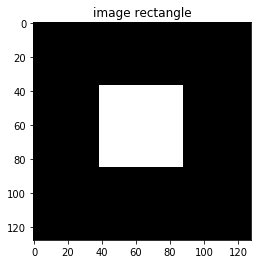

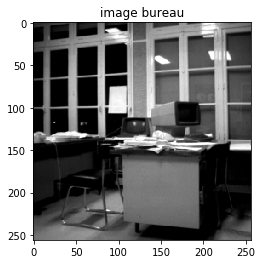

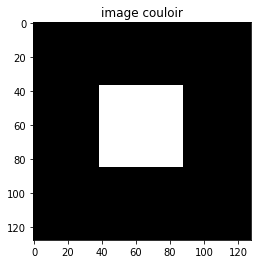

In [59]:
### Reponse 1.1

rectangle = np.array(Image.open('images/rectangle.png'))
bureau = np.array(Image.open('images/bureau.png'))
couloir = np.array(Image.open('images/couloir.png'))


affichage_14(rectangle, ['image rectangle'])
affichage_14(bureau, ['image bureau'])
affichage_14(rectangle, ['image couloir'])


In [60]:
### Réponse 1.2
def entropie(img):
    N=img.shape[0]*img.shape[1]
    his=np.histogram(img,255)[0]/N
    
    H=0

    for i in range(len(his)):
        p=his[i]
        if p>0:
            H -= log(p)*p
    H/=log(2)
    return H

print("Entropie de rectangle :",entropie(rectangle))
print("Entropie de bureau :",entropie(bureau))
print("Entropie de couloir :",entropie(couloir))


Entropie de rectangle : 0.5934730428271714
Entropie de bureau : 6.902933006980482
Entropie de couloir : 6.08323755037451


On peut fortement compresser l'image rectangle (la compression passe de 8 à 1 bits). Cependant pour les images bureau et couloir, la compression est moins importante elle passe de 8 à 7. Car l'image rectangle a moins d'informations que les autres images.

### Réponse 1.3


## Encodage des pixels avec le code de Huffman
On suppose ici connaître la dimension des images (donc leur nombre de pixels et leur nombre de lignes), et on souhaite encoder ces images en séquences binaires les plus compactes possibles.
On va pour cela utiliser le codage de Huffman.

### Question 2
1. Écrire la fonction ``huffman()`` vue  en TD. 

In [61]:
# type Noeud = tuple[int,float,list[Noeud]]

def huffman(hisn):
    """ Array[float] -> Noeud
        construit l'arbre de huffman correspondant a
        l'histogramme normalise hisn et retourne la racine.
    """
    vp=[(i, hisn[i], []) for i in range (len(hisn)) if hisn[i]>0]
    while (len(vp)>1):
        vp=sorted (vp, key=lambda x : x[1] )
        b0,b1 = vp[0], vp[1]
        vp=vp[2:]
        vp.append((-1, b0[1]+b1[1], [b0, b1]))
    return vp[0]

    

2. Testez la sur l'exemple du TD en imprimant l'arbre.

In [62]:
histo_td = np.zeros(256)
for v,f in [(0,12046),(36,3325),(73,2390),(109,8716),(146,19544),(182,18748),(219,594),(255,178)]:
    histo_td[v] = f
racine = huffman(histo_td/(256**2))
print(racine)


(-1, 1.0000762939453125, [(-1, 0.4157867431640625, [(0, 0.183807373046875, []), (-1, 0.2319793701171875, [(-1, 0.0989837646484375, [(-1, 0.048248291015625, [(-1, 0.01177978515625, [(255, 0.002716064453125, []), (219, 0.009063720703125, [])]), (73, 0.036468505859375, [])]), (36, 0.0507354736328125, [])]), (109, 0.13299560546875, [])])]), (-1, 0.58428955078125, [(182, 0.28607177734375, []), (146, 0.2982177734375, [])])])


### Question 3
1. Écrire la fonction ```hufftable()``` vu en TD.

In [63]:
def litcode(nd, code, table):
    val, p, fils=nd
    if (len(fils)>0):
        cp=code
        litcode(fils[0], code+"0", table)
        code=cp
        litcode(fils[1], code+"1", table)
    else :
        table[val]=code
    del nd
    return table

def hufftable(racine):
    """ Noeud -> dict[int,str] """
    table = dict()
    return litcode(racine, "", table)
    

2. Tester la sur l'arbre calculé précédemment et afficher la table

In [64]:
hufftable=hufftable(racine)
print(hufftable)

{0: '00', 255: '010000', 219: '010001', 73: '01001', 36: '0101', 109: '011', 182: '10', 146: '11'}


### Question 4
1. Écrire la fonction ``encode()`` vue en TD.

In [51]:
def encode(img,table):
    """ Array[int] * dict[int,str] -> tuple[bytearray,int]
        Encode l'image img selon la table de Huffman table
        retourne un tableau d'octets et la véritable longueur
        en bit des données encodés
    """
    out=bytearray([0]*img.size)
    nbits=0
    for val in img.reshape(img.size):
        for s in table[val]:
            ecritbit(out,nbits,s)
            nbits+=1
    return out,nbits


2. Tester la sur la portion d'image utilisée en TD. Afficher la taille en bit avant et après encodage.

In [52]:
img_td = np.array([
    [109, 182, 109, 109, 219, 109, 146, 182], 
    [146, 219, 182, 182, 255, 219, 219, 182],
    [219, 219, 219, 219, 219, 219, 219, 182],
    [36, 182, 73, 73, 219, 73, 109, 182], 
    [36, 146, 73, 73, 182, 73, 109, 182],
    [36, 109, 73, 73, 109, 73, 146, 182],
    [73, 36, 36, 36, 182, 146, 182, 182],
    [182, 146, 146, 146, 182, 182, 182, 182]
],dtype=int)

print("Taille de l'image :", img_td.shape[0]*img_td.shape[1])
print("Taille de l'image en bit avant l'encodage :", img_td.shape[0]*img_td.shape[1]*8)

out,nbits=encode(img_td,hufftable)

for i in range (nbits):
    print(litbit(out, i))

print("Taille de l'image en bit après l'encodage :", nbits)

Taille de l'image : 64
Taille de l'image en bit avant l'encodage : 512
0
1
1
1
0
0
1
1
0
1
1
0
1
0
0
0
1
0
1
1
1
1
1
0
1
1
0
1
0
0
0
1
1
0
1
0
0
1
0
0
0
0
0
1
0
0
0
1
0
1
0
0
0
1
1
0
0
1
0
0
0
1
0
1
0
0
0
1
0
1
0
0
0
1
0
1
0
0
0
1
0
1
0
0
0
1
0
1
0
0
0
1
0
1
0
0
0
1
1
0
0
1
0
1
1
0
0
1
0
0
1
0
1
0
0
1
0
1
0
0
0
1
0
1
0
0
1
0
1
1
1
0
0
1
0
1
1
1
0
1
0
0
1
0
1
0
0
1
1
0
0
1
0
0
1
0
1
1
1
0
0
1
0
1
0
1
1
0
1
0
0
1
0
1
0
0
1
0
1
1
0
1
0
0
1
1
1
1
0
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
1
1
1
0
1
0
1
0
1
1
1
1
1
1
1
0
1
0
1
0
1
0
Taille de l'image en bit après l'encodage : 230


3. Écrire une fonction ``print_encode()`` qui imprime le tampon encodé sous la forme d'une suite de caractères '0' et
'1'. Tester la sur l'exemple précédent.

In [53]:
def print_encoded( encoded, l):
    """ bytearray*int->str"""
    res=''
    for bit in range(l):
        res+=litbit(encoded,bit)
    return res

## Test
print_encoded(out,nbits) 

'01110011011010001011111011010001101001000001000101000110010001010001010001010001010001010001010001100101100100101001010001010010111001011101001010011001001011100101011010010100101101001111001001010101010101101110101011111110101010'

### Question 5
1. Écrire le code de la fonction ```decode()``` vu en TD.

In [54]:
def decode(encoded,shape,table):
    """ bytearray*tuple[int,int]*dict[int,str]->Array[int]
        decode une image de huffman
    """
    out=np.zeros(shape)
    bit=0
    table2={code:val for val,code in table.items()}
    
    for i in range(out.size):
        code=''
        while code not in table2:
            code+=litbit(encoded,bit)
            bit+=1    
        out[i//shape[0]][i%shape[0]]=table2[code]
    return out.reshape(shape)

2. Tester la sur la portion d''image précédemment encodée et vérifier qu'elle est bien égale à la portion d'image originale.

In [55]:
decode(out,img_td.shape,hufftable)

array([[109., 182., 109., 109., 219., 109., 146., 182.],
       [146., 219., 182., 182., 255., 219., 219., 182.],
       [219., 219., 219., 219., 219., 219., 219., 182.],
       [ 36., 182.,  73.,  73., 219.,  73., 109., 182.],
       [ 36., 146.,  73.,  73., 182.,  73., 109., 182.],
       [ 36., 109.,  73.,  73., 109.,  73., 146., 182.],
       [ 73.,  36.,  36.,  36., 182., 146., 182., 182.],
       [182., 146., 146., 146., 182., 182., 182., 182.]])

### Question 5: expérimentations

1. Vérifier, pour les trois images, que la compression huffman fonctionne correctement

2. On définit le taux de compression d'une image par : *1 - (taille_bit_code / taille_bit_image) %* Calculez les taux de compression des trois images. Commentez.  
 
3. Quel serait le taux de compression d'une image avec pixels aléatoires de loi uniforme [0,255] ? Quel est le lien avec la valeur de l'entropie des pixels ?

In [77]:
def histo (img):
    histo = np.zeros(256)
    x, y=img.shape
    for i in range (x):
        for j in range (y) :
            histo[img[i][j]]+=1
    return histo

#Rectangle

print("Entropie de rectangle :",entropie(rectangle))
histo_rec = histo(rectangle)
racine_rec = huffman(histo_rec/(rectangle.shape[0]*rectangle.shape[1]))
print("Racine rectangle : ", racine_rec)
hufftable_rec=hufftable(racine_rec)
print("Hufftable rectangle : ", hufftable_rec)
out_r,nbits_r=encode(rectangle,hufftable_rec)
print_encoded(out_r,nbits_r) 
decode(out_r,rectangle.shape,hufftable_rec)

#Couloir

print("Entropie de couloir :",entropie(couloir))
histo_cou = histo(couloir)
racine_cou = huffman(histo_cou/(couloir.shape[0]*couloir.shape[1]))
print("Racine couloir : ", racine_cou)
hufftable_cou=hufftable(racine_cou)
print("Hufftable couloir : ", hufftable_cou)
out_c,nbits_c=encode(couloir,hufftable_cou)
print_encoded(out_c,nbits_c) 
decode(out_c,couloir.shape,hufftable_cou)

#Bureau

print("Entropie de bureau :",entropie(bureau))
histo_bur = histo(bureau)
racine_bur = huffman(histo_bur/(bureau.shape[0]*bureau.shape[1]))
print("Racine bureau : ", racine_bur)
hufftable_bur=hufftable(racine_bur)
print("Hufftable bureau : ", hufftable_bur)
out_b,nbits_b=encode(bureau,hufftable_bur)
print_encoded(out_b,nbits_b) 
decode(out_b,bureau.shape,hufftable_bur)



Entropie de rectangle : 0.5934730428271714
Racine rectangle :  (-1, 1.0, [(255, 0.1435546875, []), (0, 0.8564453125, [])])


TypeError: 'dict' object is not callable

**Réponse question 5.3**

In [79]:
 #1 - (taille_bit_code / taille_bit_image) %

#Rectangle

print("Taux de compression de rectangle : ", (1 - (nbits_r / (rectangle.shape[0]*rectangle.shape[1]*8)), "%"))

#Couloir

print("Taux de compression de couloir : ", (1 - (nbits_c / (couloir.shape[0]*couloir.shape[1]*8)), "%"))

#Bureau

print("Taux de compression de bureau : ", (1 - (nbits_b / (bureau.shape[0]*bureau.shape[1]*8)), "%"))

NameError: name 'nbits_r' is not defined